## DATA
https://datasciencecapstone.org/competitions/9/predicting-chronic-hunger/page/29/


## Infile and EDA

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from fancyimpute import KNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
train_y = pd.read_csv('D:/Download/train_labels.csv')
train_x = pd.read_csv('D:/Download/train_values_6tLXv3T.csv')
test = pd.read_csv('D:/Download/test_values_K7FqC54.csv')
print(train_x.shape,train_y.shape,test.shape)
# train_x.columns
print(train_y.prevalence_of_undernourishment.describe())

(1401, 46) (1401, 2) (616, 46)
count    1401.000000
mean       15.510697
std        11.610440
min         2.493428
25%         5.710856
50%        12.118656
75%        22.447492
max        59.089781
Name: prevalence_of_undernourishment, dtype: float64


In [46]:
#To Answer Data Exploration Questions
# df =train_x
# df['target'] = train_y.prevalence_of_undernourishment
# x = df.groupby('year')
# x.median().target
# x.mean().target


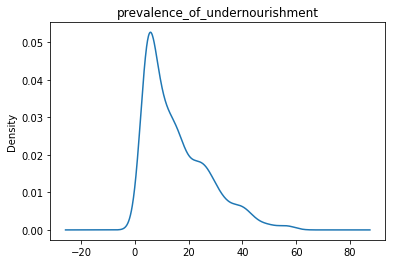

In [47]:
#target distribution
train_y.prevalence_of_undernourishment.plot(kind='density',title='prevalence_of_undernourishment')

In [48]:
#print correlation between y and columns
imp_num=[]
imp=[]
for i in train_x.columns[3:-1]:
    tmp = train_y.prevalence_of_undernourishment.corr(train_x[i])
    print(i,':',tmp)
    imp += [abs(tmp)]
    if abs(tmp)>0.5:
        imp_num += [i]
#         print(i,':',tmp)
# plt.plot(df_num.columns,imp)
print(imp_num)

agricultural_land_area : 0.006627019407177683
percentage_of_arable_land_equipped_for_irrigation : -0.13804832873565062
cereal_yield : -0.2494697494931741
droughts_floods_extreme_temps : 0.23699225101399282
forest_area : -0.003169208649612557
total_land_area : -0.002453393428038266
fertility_rate : 0.49710752762865207
life_expectancy : -0.4762636882424877
rural_population : 0.054463319809451495
total_population : 0.025694981997350843
urban_population : -0.0337592314931599
population_growth : 0.2552048982710409
avg_value_of_food_production : -0.38971999758215176
cereal_import_dependency_ratio : 0.04633042477600196
food_imports_as_share_of_merch_exports : 0.1817559386257268
gross_domestic_product_per_capita_ppp : -0.33551291971331765
imports_of_goods_and_services : -0.0015793586431821613
inequality_index : 0.18479907925171132
net_oda_received_percent_gni : 0.37788788969121
net_oda_received_per_capita : 0.021530719418286673
tax_revenue_share_gdp : -0.18108905400981284
trade_in_services : 0

Catogory: Index(['country_code', 'year'], dtype='object')


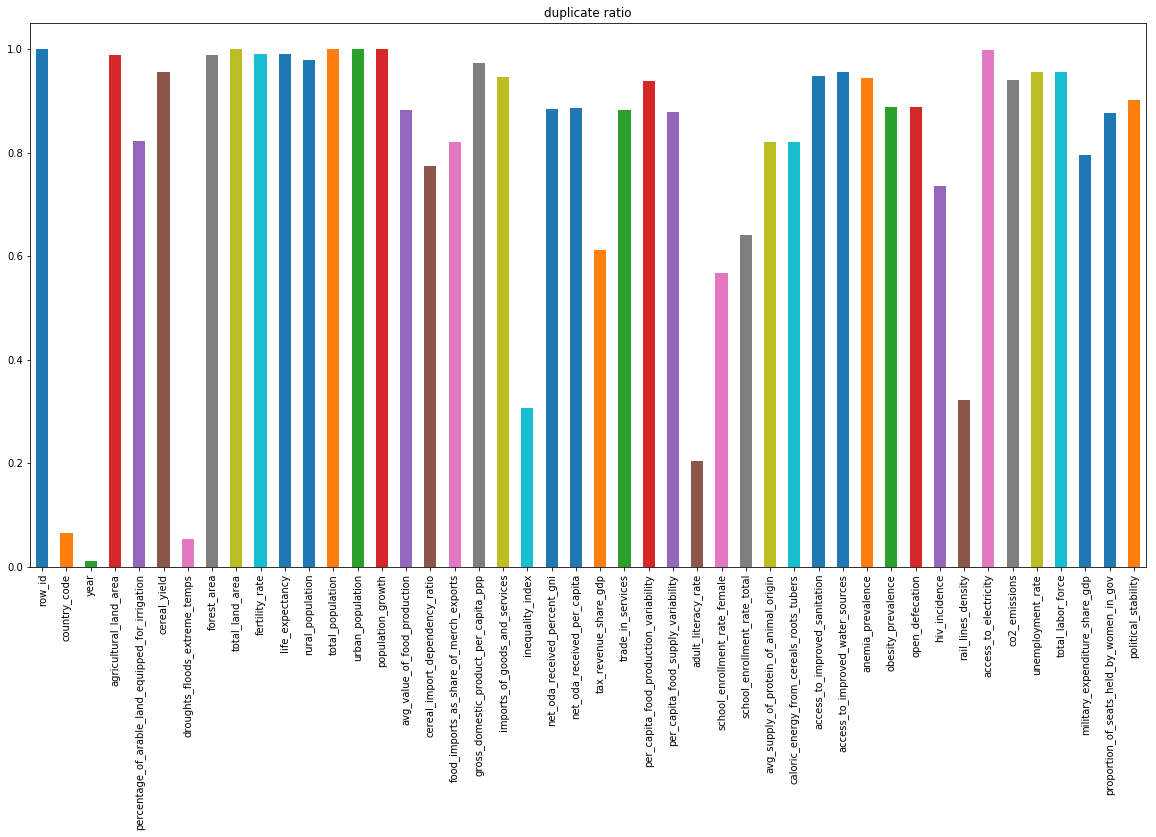

In [49]:
# duplicate ratio
plt.figure(figsize=(20,10))
(train_x.apply(lambda x:x.unique().shape[0],axis=0)/train_x.shape[0]).plot(kind='bar',title='duplicate ratio')
print('Catogory:',train_x.columns[1:3])
#check whether id has duplicate rows
assert len(train_x.row_id.unique())-train_x.shape[0]==0

## Handle missing values

na.ratio>0.4 :
droughts_floods_extreme_temps    0.946467
inequality_index                 0.693790
adult_literacy_rate              0.796574
school_enrollment_rate_female    0.432548
rail_lines_density               0.673804
dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


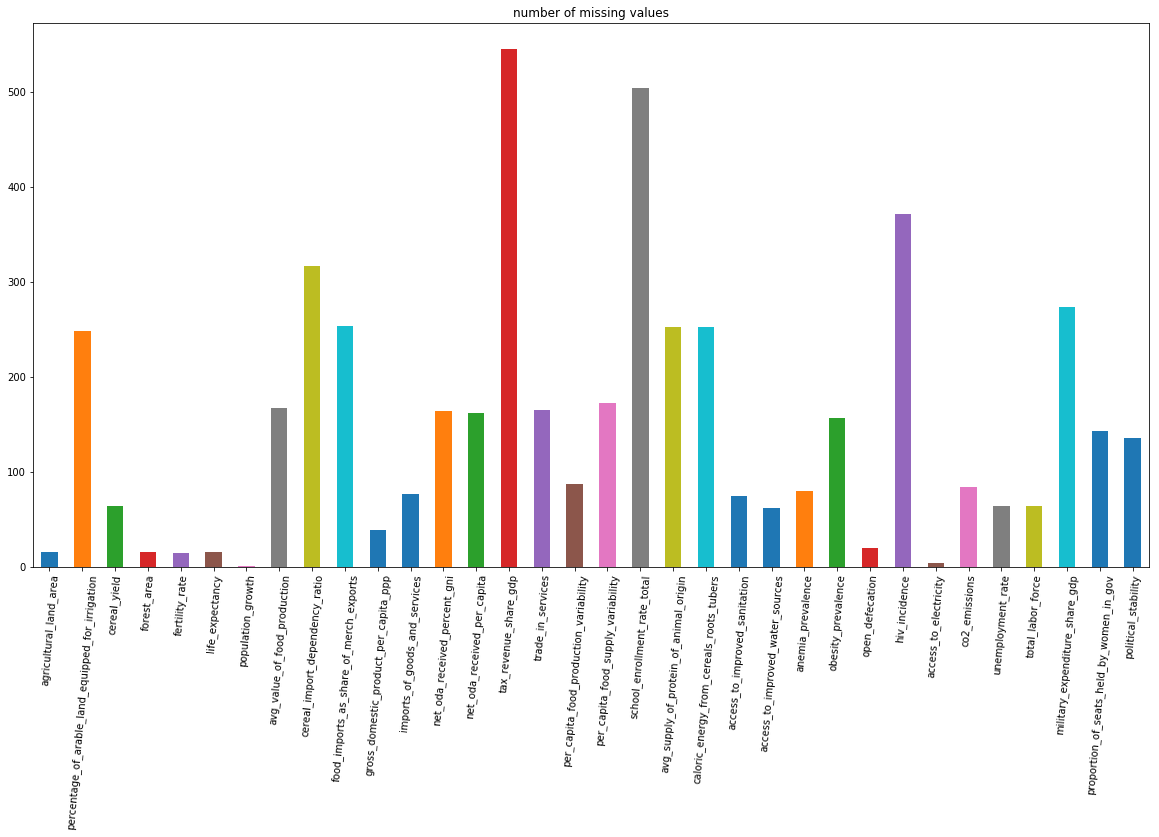

In [50]:
#remove na.ratio>0.4 columns
na_ratio = train_x.isna().sum()/train_x.shape[0]
tmp = na_ratio[na_ratio>0.4]
print('na.ratio>0.4 :',tmp,sep='\n')
droped_columns=tmp.index
train_x = train_x.drop(columns=droped_columns)
tmp = train_x.isna().sum()/train_x.shape[0]
tmpp = tmp[tmp>0]
plt.figure(figsize=(20,10))
print(train_x[tmpp.index].isnull().sum().plot(kind='bar',rot=85,title='number of missing values'))

AxesSubplot(0.125,0.125;0.775x0.755)


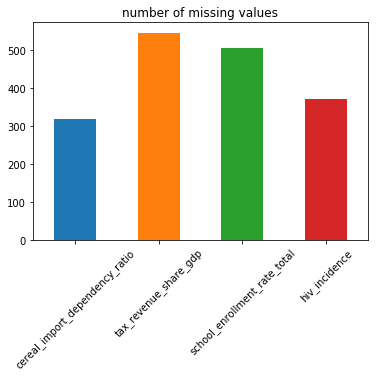

In [51]:
#rest high na_ratio columns
tmpp = tmp[tmp>0.2]
print(train_x[tmpp.index].isnull().sum().plot(kind='bar',rot=45,title='number of missing values'))

In [52]:
#fillna with KNN
train_x2 = KNN(k=5).fit_transform(train_x.iloc[:,3:])
train_x_df = pd.DataFrame(data=train_x2,index=range(1401),columns=train_x.columns[3:])
train_x_df['year'] = train_x.year
train_x = train_x_df
assert train_x.shape[1]==39
assert train_x.isna().any().sum()==0

Imputing row 1/1401 with 3 missing, elapsed time: 0.499
Imputing row 101/1401 with 0 missing, elapsed time: 0.499
Imputing row 201/1401 with 5 missing, elapsed time: 0.514
Imputing row 301/1401 with 0 missing, elapsed time: 0.514
Imputing row 401/1401 with 0 missing, elapsed time: 0.514
Imputing row 501/1401 with 1 missing, elapsed time: 0.530
Imputing row 601/1401 with 1 missing, elapsed time: 0.530
Imputing row 701/1401 with 2 missing, elapsed time: 0.530
Imputing row 801/1401 with 0 missing, elapsed time: 0.545
Imputing row 901/1401 with 1 missing, elapsed time: 0.545
Imputing row 1001/1401 with 4 missing, elapsed time: 0.545
Imputing row 1101/1401 with 2 missing, elapsed time: 0.561
Imputing row 1201/1401 with 2 missing, elapsed time: 0.561
Imputing row 1301/1401 with 18 missing, elapsed time: 0.561
Imputing row 1401/1401 with 0 missing, elapsed time: 0.577


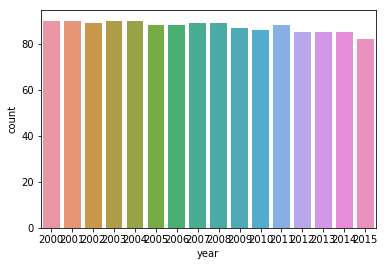

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


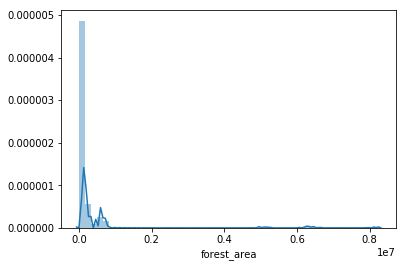

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


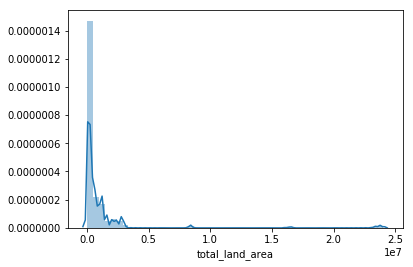

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


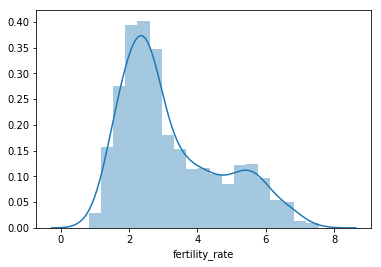

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


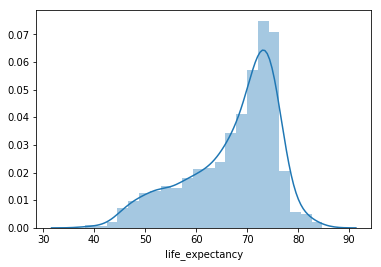

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


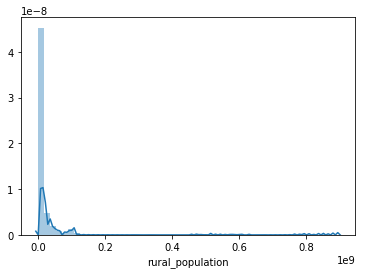

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


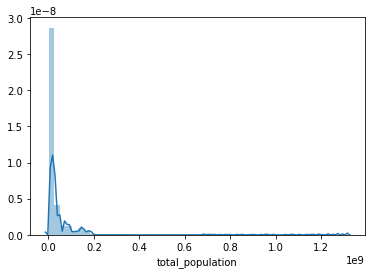

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


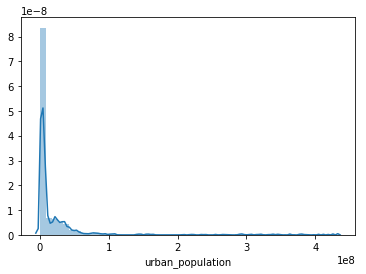

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


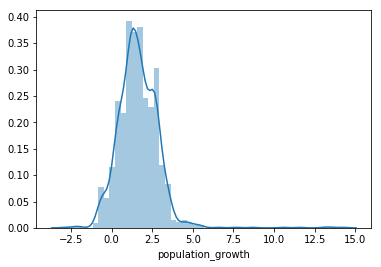

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


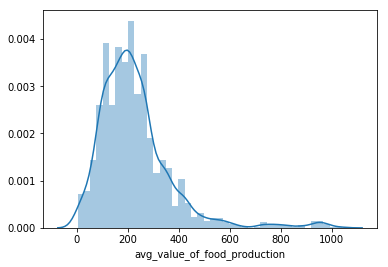

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


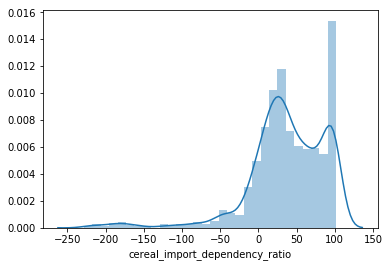

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


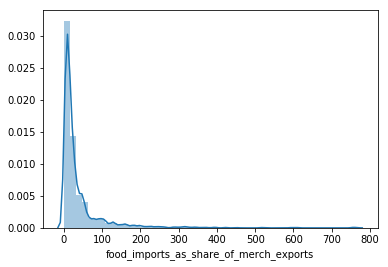

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


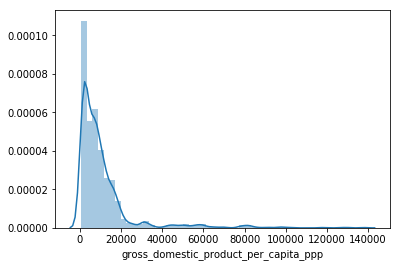

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


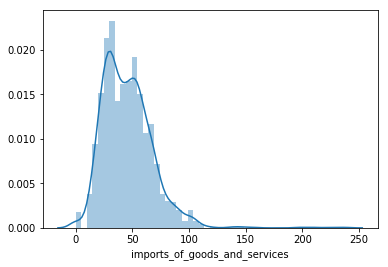

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


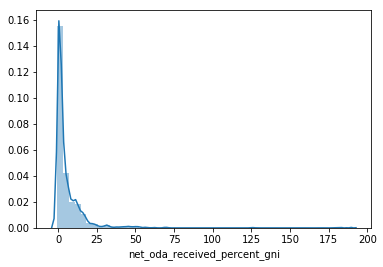

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


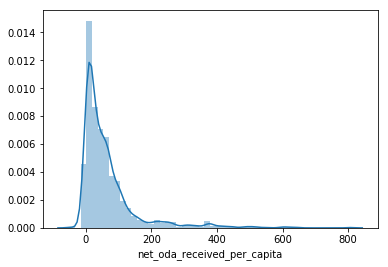

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


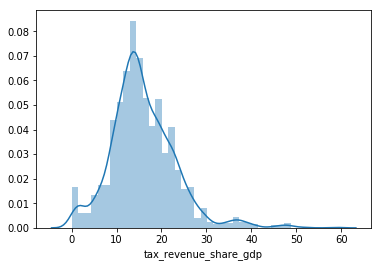

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


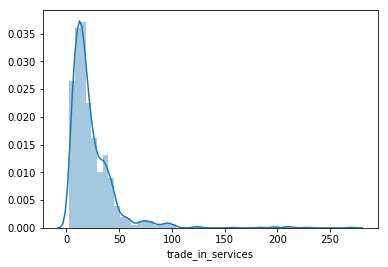

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


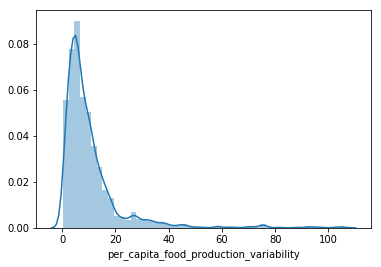

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


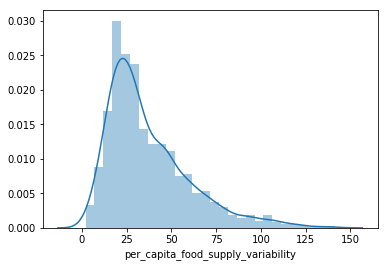

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


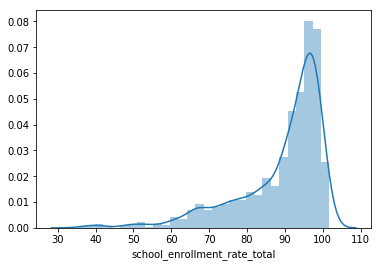

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


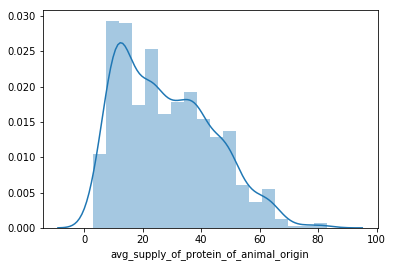

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


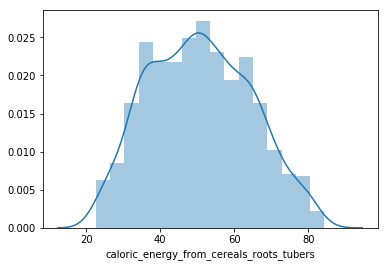

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


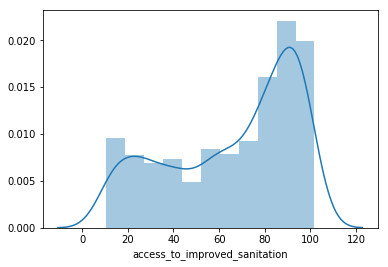

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


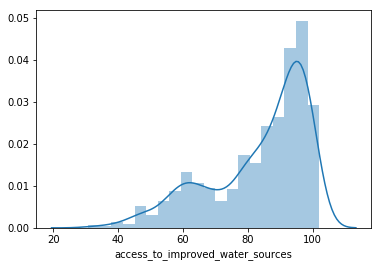

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


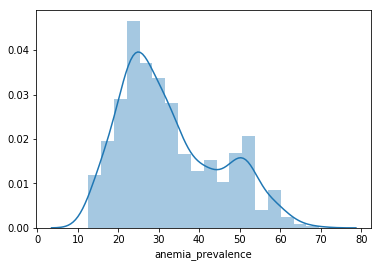

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


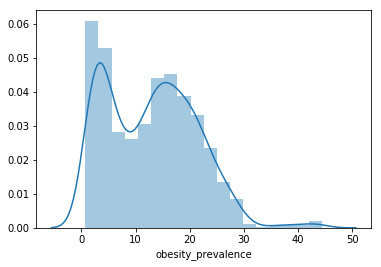

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


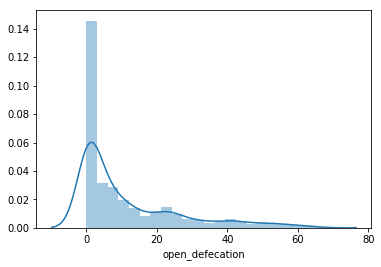

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


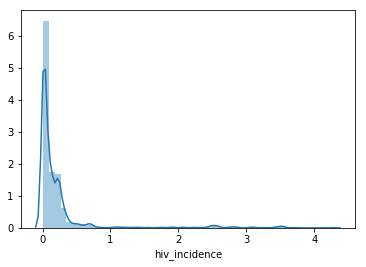

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


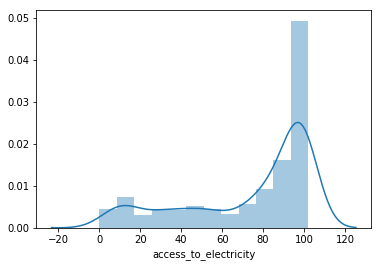

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


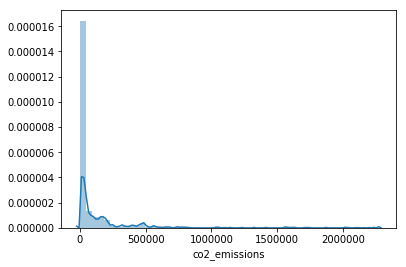

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


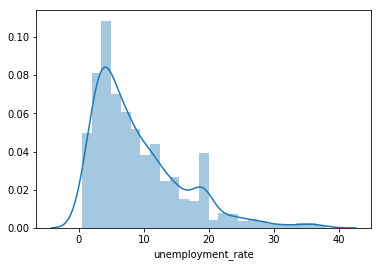

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


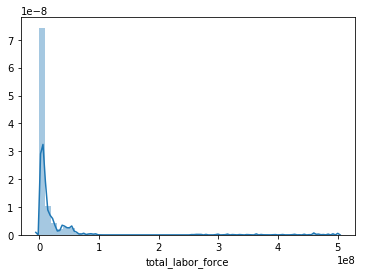

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


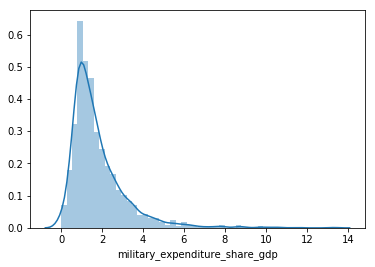

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


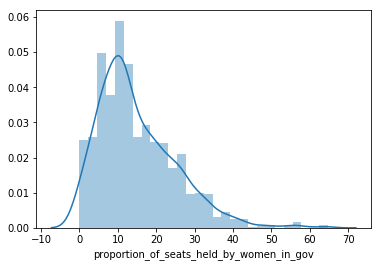

C:\Users\Mozzie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


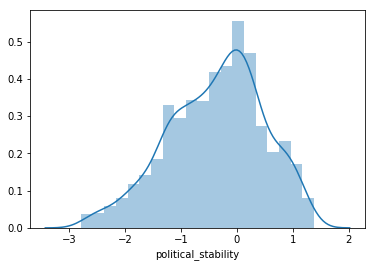

In [53]:
#print columns distribution
sns.countplot(x='year', data=train_x)
plt.show()
for i in train_x.columns[3:-1]:
    sns.distplot(train_x[i])
    plt.show()

## Handle ouliers

In [54]:
#replace outliers
for col in train_x.columns[3:-1]:
    scaler = StandardScaler()
    scaler.fit(train_x[[col]])
    ss = scaler.transform(train_x[[col]])
    maxv = ss.mean()+3*ss.std()
    minv = ss.mean()-3*ss.std()
    for i in range(len(ss)):
        if ss[i]<minv:
            ss[i] = minv
        if ss[i]>maxv:
            ss[i] = maxv
    train_x[col] = scaler.inverse_transform(ss)

## Dealing with Multi-Collinearity problem

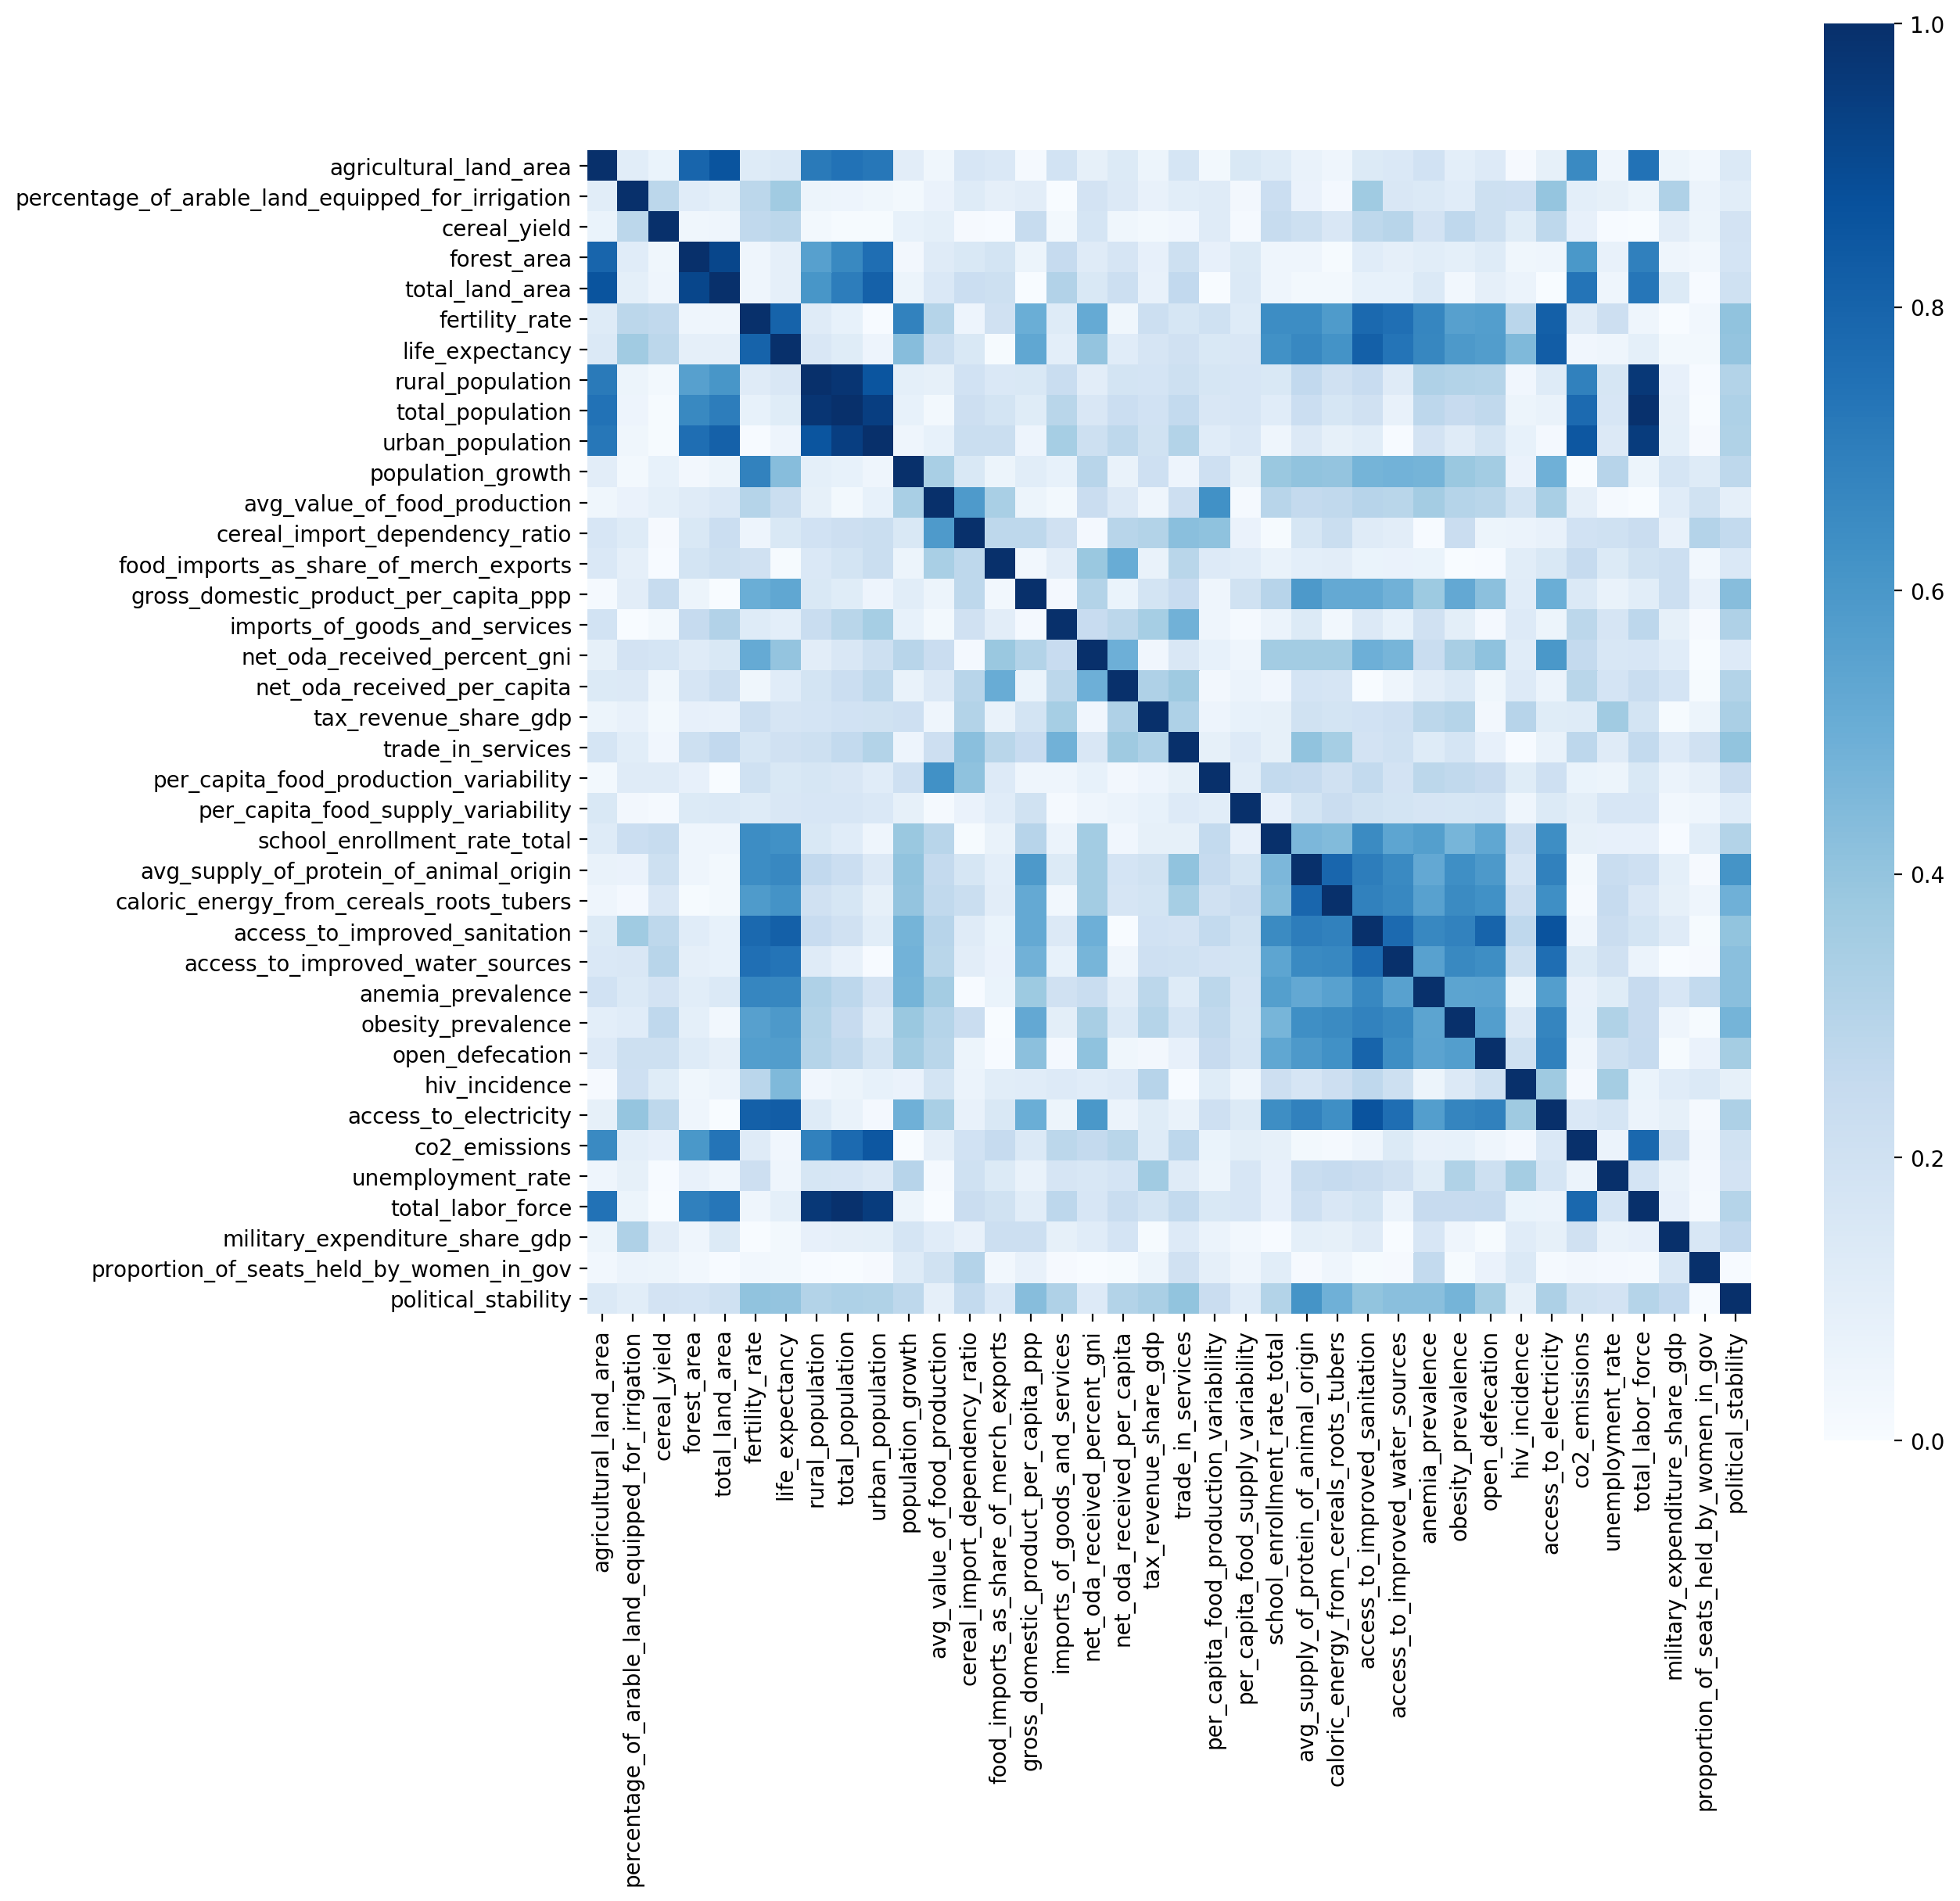

In [55]:
#print correlation table
plt.figure(figsize=(12,12),dpi=200)
sns.heatmap( abs(train_x.drop(columns=['year']).corr()),cmap="Blues",
             vmin=0,
             vmax=1,
             square=True,
             annot=False)
plt.show()

In [56]:
#list high correlation column pairs
tmp = abs(train_x.drop(columns=['year']).corr())
tmpp = tmp[tmp!=1]
pair=[]
prePCA=[]
for i in range(tmpp.shape[0]):
    for j in range(tmpp.shape[0]):
        if tmpp.iloc[i,j]>0.7:
            pair += [tmpp.columns[i]+tmpp.columns[j]]
            if tmpp.columns[j]+tmpp.columns[i] not in pair:
                print(tmpp.columns[i],'--------',tmpp.columns[j])
                prePCA+=[(tmpp.columns[i],tmpp.columns[j])]


agricultural_land_area -------- forest_area
agricultural_land_area -------- total_land_area
agricultural_land_area -------- rural_population
agricultural_land_area -------- total_population
agricultural_land_area -------- urban_population
agricultural_land_area -------- total_labor_force
forest_area -------- total_land_area
forest_area -------- urban_population
total_land_area -------- total_population
total_land_area -------- urban_population
total_land_area -------- co2_emissions
total_land_area -------- total_labor_force
fertility_rate -------- life_expectancy
fertility_rate -------- access_to_improved_sanitation
fertility_rate -------- access_to_improved_water_sources
fertility_rate -------- access_to_electricity
life_expectancy -------- access_to_improved_sanitation
life_expectancy -------- access_to_improved_water_sources
life_expectancy -------- access_to_electricity
rural_population -------- total_population
rural_population -------- urban_population
rural_population -------- t

In [57]:
#list columns might have Multi-Collinearity problem
flattened_list = set([y for x in prePCA for y in x])
print(flattened_list)

{'rural_population', 'total_labor_force', 'total_land_area', 'co2_emissions', 'fertility_rate', 'avg_supply_of_protein_of_animal_origin', 'access_to_improved_sanitation', 'total_population', 'agricultural_land_area', 'access_to_electricity', 'access_to_improved_water_sources', 'urban_population', 'forest_area', 'caloric_energy_from_cereals_roots_tubers', 'life_expectancy', 'open_defecation'}


In [58]:
#try to fix Multi-Collinearity problem

train_x['rural_population'] = train_x.rural_population/train_x.total_population
train_x['urban_population'] = train_x.urban_population/train_x.total_population
train_x['agricultural_land_area'] = train_x.agricultural_land_area/train_x.total_land_area
train_x['forest_area'] = train_x.forest_area/train_x.total_land_area
train_x.rename(columns={'rural_population':'rural_population_ratio',
               'urban_population':'urban_population_ratio',
               'agricultural_land_area':'agricultural_land_area_ratio',
               'forest_area':'forest_area_ratio'},inplace=True)

def Polymerization(cols,new_name,data):
    pca = PCA(n_components=1)
    new_col = pca.fit_transform(data[cols])
    data.drop(columns=cols,inplace=True)
    data[new_name]=new_col
    return data

health_food = ['avg_supply_of_protein_of_animal_origin','caloric_energy_from_cereals_roots_tubers']
health_facility = ['life_expectancy','access_to_improved_sanitation','access_to_improved_water_sources','access_to_electricity','fertility_rate']
Polymerization(health_food,'health_food',train_x)
Polymerization(health_facility,'health_facility',train_x)
print(train_x.shape)

(1401, 34)


## One-hot encoding

In [59]:
#one-hot encoding catogory column
train_x = pd.get_dummies(data=train_x,columns=['year'])
print(train_x.shape)

(1401, 49)


## Prepare test data

In [60]:
def prepare_test(test):
    test.drop_duplicates(subset=['row_id'],inplace=True)
    test.drop(columns=['row_id','country_code'],inplace=True)
    test.drop(columns=droped_columns,inplace=True)
    knn = KNN(k=5).fit_transform(test.drop(columns=['year']))
    test2 = pd.DataFrame(data=knn,index=range(test.shape[0]),columns=test.drop(columns=['year']).columns)    
    test2['year'] = test.year
    assert test2.shape[1]==39
    assert test2.isna().any().sum()==0
    test2['rural_population'] = test2.rural_population/test2.total_population
    test2['urban_population'] = test2.urban_population/test2.total_population
    test2['agricultural_land_area'] = test2.agricultural_land_area/test2.total_land_area
    test2['forest_area'] = test2.forest_area/test2.total_land_area
    test2.rename(columns={'rural_population':'rural_population_ratio',
               'urban_population':'urban_population_ratio',
               'agricultural_land_area':'agricultural_land_area_ratio',
               'forest_area':'forest_area_ratio'},inplace=True)
    assert test2.isna().any().sum()==0
    Polymerization(health_food,'health_food',test2)
    Polymerization(health_facility,'health_facility',test2)
    test2 = pd.get_dummies(data=test2,columns=['year'])
    return test2
test = prepare_test(test)

Imputing row 1/616 with 3 missing, elapsed time: 0.104
Imputing row 101/616 with 1 missing, elapsed time: 0.104
Imputing row 201/616 with 0 missing, elapsed time: 0.104
Imputing row 301/616 with 1 missing, elapsed time: 0.104
Imputing row 401/616 with 12 missing, elapsed time: 0.120
Imputing row 501/616 with 1 missing, elapsed time: 0.120
Imputing row 601/616 with 10 missing, elapsed time: 0.120


In [17]:
#Save cleaned datasets
# train_x.to_csv('D:/cleaned_train_x.csv',index=False)
# train_y.iloc[:,1].to_csv('D:/cleaned_train_y.csv',index=False)

In [42]:
train_hf.shape,test_hf.shape

((1401, 1), (616, 1))

In [61]:
#Standardlization
train_x_org = train_x.copy()
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test = scaler.transform(test)
train_x.shape,train_y.shape,test.shape

((1401, 49), (1401, 2), (616, 49))

In [19]:
train_x.shape,train_y.prevalence_of_undernourishment.shape,test.shape

((1401, 49), (1401,), (616, 49))

## Feature selection

In [21]:
#feature selection
lcv = LassoCV(cv=10,alphas=[i/10000 for i in range(1000,15000,5)])
lcv.fit(train_x, train_y.iloc[:,1])
df_features = pd.DataFrame()
df_features['feature']=train_x_org.columns
df_features['coef']=lcv.coef_
df = df_features[abs(df_features.coef)>0]
# print(df.shape)
# df.sort_values('coef')

(37, 2)


,feature,coef
21,anemia_prevalence,-2.717874
22,obesity_prevalence,-2.576662
9,avg_value_of_food_production,-2.046897
30,political_stability,-1.868730
24,hiv_incidence,-1.352519
6,total_population,-1.041570
16,tax_revenue_share_gdp,-0.819035
13,imports_of_goods_and_services,-0.532720
25,co2_emissions,-0.411878
2,cereal_yield,-0.371198


In [62]:
#feature selection
lcv = LassoCV(cv=10,alphas=[i/10000 for i in range(10000,15000,5)])
sfm = SelectFromModel(lcv, threshold=0.25)
sfm.fit(train_x, train_y.iloc[:,1])
tmp = sfm.transform(train_x)
tmp2 = sfm.transform(test)
tmp.shape,tmp2.shape
# assert tmp.shape[1]==tmp2.transform(train_x).shape[1]

((1401, 7), (616, 7))

## simple linear regresion

In [41]:
train_hf = train_x.health_facility
test_hf = test.health_facility
scaler = StandardScaler()
scaler.fit(pd.DataFrame(train_hf))
train_hf = scaler.transform(pd.DataFrame(train_hf))
test_hf = scaler.transform(pd.DataFrame(test_hf))

In [43]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
model = regressor.fit(train_hf,train_y.iloc[:,1])
pred_y = model.predict(test_hf)
pred_y

array([ 5.43439771,  6.17207815, 10.14303952, 21.19029729, 19.58771895,
       16.72673102, 17.17950206, 25.13760723, 27.21449351, 28.69457709,
        5.83387376, 20.08883657,  8.63334386,  6.76996919, 26.1093283 ,
       22.11374439, 28.10643784,  9.22461286,  5.77698317, 23.9623233 ,
       25.88383427, 22.89742479,  5.94530975,  5.01956206,  9.10494102,
       22.46537737, 18.88606885,  8.89700235,  6.20432506,  6.64521515,
        7.67488848, 10.28442068,  5.74555984,  5.76542145,  6.93443357,
       26.42677118, 27.23653038,  5.90434827,  6.15651699, 26.37328665,
       15.64342374, 27.20924843, 16.22079062,  6.54382639,  5.7588987 ,
       15.80769621, 26.2703496 ,  8.93051692, 28.34684985, 24.48085829,
        7.74213914,  8.10641942,  6.5640558 , 12.2213479 , 21.14613072,
        5.9415054 ,  5.52247026,  6.53898849, 28.67353147,  7.324835  ,
       25.44031035, 20.85760186, 17.84553305, 21.33608961, 25.11774896,
       20.20253661,  7.85654067,  8.91299437,  7.53919198, 25.74

## Random forest model

In [ ]:
#Fitting RandomForest regressor
regr = RandomForestRegressor(n_estimators=271,oob_score=True,n_jobs=-1)
regr.fit(train_x, train_y.iloc[:,1])
pred_y = regr.predict(test)
print(pred_y)

In [63]:
#Fitting RandomForest regressor with lesso feature selection
regr = RandomForestRegressor(max_depth=20, max_leaf_nodes=99,n_estimators=100,max_features=3,oob_score=True,n_jobs=-1)
regr.fit(tmp, train_y.iloc[:,1])
pred_y = regr.predict(tmp2)
print(pred_y)

[ 5.45897057  5.71399201 10.97752749 26.48606156 13.37201651 19.45843717
 18.87330944 23.81320562 28.96438767 29.84105177 12.90681945 15.93871444
  6.35800873  8.31681272 31.26433547 21.76892536 35.20681562  9.53746624
  9.75240153 14.62787498 17.22440156 17.06157603  4.95342351  5.08891984
  9.71925727 16.14063616 13.45629654 11.13638777  5.91085675  8.42903078
 18.07867657 10.68018829  7.6310764  10.085916   18.53303146 28.1798124
 36.94774283  5.48598429  5.49653467 21.68796535 17.04549107 19.315134
 15.21994694 17.68576262  5.57503488 14.74407361 32.42504513  9.90506283
 30.85639298 19.81082119 15.5768713  15.79231193  6.68334576 11.87945485
 25.37095344  8.39937876  6.52637735  8.14255312 31.53262087 18.52472506
 18.04576042 29.41703512 18.2914975  26.87226495 16.45528394 16.61622052
  7.70438515  6.13491907  7.37116451 24.65777356 14.5995049  22.07619049
  5.4978391  13.26696384 26.68138674 11.22328889 28.81412617 13.95960584
 12.35524086  9.09266179 18.15766744 17.89009033 10.25

In [ ]:
plt.plot(regr.predict(tmp)-train_y.iloc[:,1])

In [ ]:
regr.score(train_x,train_y.iloc[:,1])

In [ ]:
regr.score(tmp,train_y.iloc[:,1])

## xgboosting regrssor

In [ ]:
#Fitting XGB regressor 
# xgbm = xgb.XGBRegressor(n_estimators=2500,learning_rate=0.001,max_depth=9999999,min_child_weight=1,n_jobs=-1)
# print(xgbm)
# xgbm.fit(train_x,train_y.iloc[:,1])
# pred_y2 = xgbm.predict(test)
# print(pred_y2)

## Write out summition

In [64]:
# output
summit=pd.DataFrame()
summit['row_id']=range(test.shape[0])
summit['prevalence_of_undernourishment']=pred_y
summit.to_csv('D:/summit.csv',index=False)

## Grid search estimators

In [ ]:
##gridsearch 10fold
rf = RandomForestRegressor(n_estimators=150,oob_score=True,max_features='sqrt')
param_test1 = {'n_estimators':range(270,280),'max_depth':range(18,25),'max_leaf_nodes':range(90,100),'max_features':range(2,15)}
gsearch1 = GridSearchCV(rf,param_test1,cv=10,scoring='neg_mean_squared_error',n_jobs=3)
gsearch1.fit(tmp,train_y.iloc[:,1])
print(gsearch1.best_params_)
# {'max_depth': 22, 'n_estimators': 275}
#{'n_estimators':range(270,500,5)} {'n_estimators': 465}
#{'max_depth': 22, 'max_leaf_nodes': 95, 'n_estimators': 275}